In [106]:
import sqlite3
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge

In [107]:
def calculate_distance(lat1, lon1):
    # Radius of the Earth in kilometers
    earth_radius = 6371

    # Convert latitude and longitude to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(44.4914)
    lon2_rad = math.radians(20.2744)

    # Calculate the differences between the latitudes and longitudes
    d_lat = lat2_rad - lat1_rad
    d_lon = lon2_rad - lon1_rad

    # Apply the Haversine formula
    a = math.sin(d_lat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(d_lon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = earth_radius * c

    return distance

In [108]:
values = ["SUT", "PSUT", "PR", "VPR"]

mapping = {
    "SUT": 0,
    "PSUT": 0.25,
    "PR": 0.5,
    "VPR": 0.75
}

# Connect to the database
conn = sqlite3.connect('db_prodaja-stanova_beograd.db')

# Create a cursor object
cursor = conn.cursor()
df = pd.read_sql_query("SELECT * FROM mytable", conn)

# Execute a SELECT query
cursor.execute("SELECT * FROM mytable")

X_data = list()
Y_data = list()
full_data = list()

# Fetch and print rows one by one
row1 = cursor.fetchone()
row = cursor.fetchone()
while row is not None:
    coordinates = row[4]
    latitude, longitude = coordinates.split(',')
    distance = calculate_distance(float(latitude), float(longitude))

    broj_soba = row[5]

    if broj_soba == None:
        row = cursor.fetchone()
        continue
    broj_soba = float(broj_soba) if broj_soba != '5+' else 5.0

    kvadratura = float(row[6])
    if kvadratura == None:
        row = cursor.fetchone()
        continue

    sprat = row[7]
    if sprat == None:
        row = cursor.fetchone()
        continue
    if sprat in values:
        sprat = mapping[sprat]
    else:
        sprat = float(sprat)
    sprat = math.log2(sprat + 1)

    tip_gradnje = row[8]
    tip_gradnje = 1 if tip_gradnje == 'Novogradnja' else 0
    uknjizen = float(row[9])
    lift = float(row[10])
    garaza = float(row[11])
    terasa = float(row[12])
    pdv = float(row[13])
    cena = float(row[16])

    row_x_data = [distance, broj_soba, kvadratura, sprat, tip_gradnje, uknjizen, lift, garaza, terasa, pdv]
    row_full_data = [distance, broj_soba, kvadratura, sprat, tip_gradnje, uknjizen, lift, garaza, terasa, pdv, cena]
    full_data.append(row_full_data)
    X_data.append(row_x_data)
    Y_data.append(cena)

    row = cursor.fetchone()

# Close the connection
conn.close()

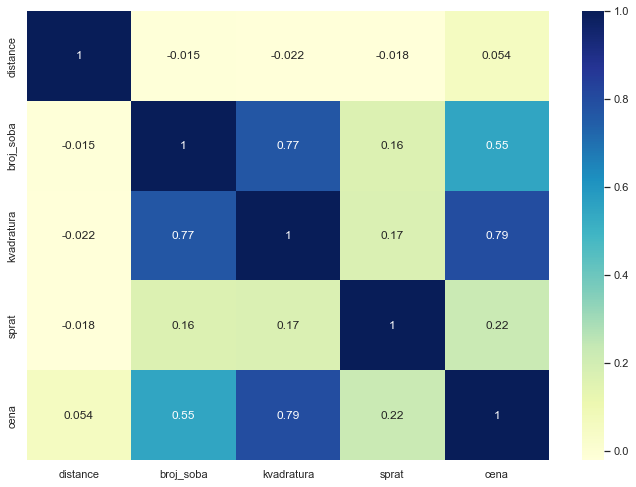

In [122]:
header = ['distance', 'broj_soba', 'kvadratura', 'sprat', 'cena']
df = pd.DataFrame(full_data, columns=header)
sns.set(rc={'figure.figsize':(11.7,8.27)})
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)

Za polinomijalnu regresiju koristimo samo 4 prediktora iz razloga što su ostali prediktori kategorički.

In [110]:
df.head()

,distance,broj_soba,kvadratura,sprat,cena
0,39.127679,3.0,68.0,1.000000,194000.0
1,35.570932,2.5,75.0,3.459432,155000.0
2,34.167384,3.0,69.0,2.000000,265000.0
3,37.692401,4.0,146.0,4.169925,665000.0
4,37.751948,4.0,125.0,2.000000,480000.0


In [111]:
header = ['distance', 'broj_soba', 'kvadratura', 'sprat', 'cena']
df_x = pd.DataFrame(X_data, columns=header)
y_data = df_x['cena']
MinMaxScaler = preprocessing.MinMaxScaler()
df_x.pop("cena")
X_values = df_x.values
y = y_data.values

In [112]:
from sklearn.model_selection import KFold
k = 4
kf = KFold(n_splits=k, shuffle=True)

(9587, 5)
(9587, 15)
(9587, 35)


(9587, 70)
(9587, 126)
(9587, 210)
(9587, 330)
(9587, 495)
(9587, 715)
(9587, 1001)
(9587, 1365)
(9587, 1820)
(9587, 2380)
(9587, 3060)
[11145068740.726349, 10874382289.545189, 11607093913.676785, 20561683586.44929, 357727383396.48083, 3382410809966.3755, 1576734491428830.2, 6417227562192383.0, 2.3733856697819827e+18, 9.283010597384386e+20, 1.800438068892304e+23, 5.094535105784095e+25, 1.9507929380069588e+26, 7.283047917917971e+27]


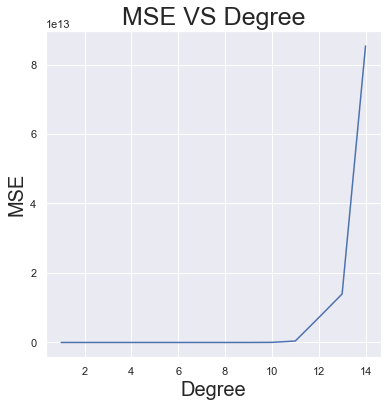

In [113]:
X = MinMaxScaler.fit_transform(X_values.copy())
x_train,x_test,y_train,y_test=train_test_split(X,y,train_size=0.8, random_state = 1)
maxdegree=15 # The maximum degree we would like to test
training_error=[]
cross_validation_error=[]
for d in range(1,maxdegree):
    x_poly_train=PolynomialFeatures(degree=(0,d)).fit_transform(x_train)
    print(np.shape(x_poly_train))
    x_poly_test=PolynomialFeatures(degree=(0,d)).fit_transform(x_test)
    model=LinearRegression(fit_intercept = False)
    model=model.fit(x_poly_train,y_train)
    y_train_pred=model.predict(x_poly_train)
    mse_train=mean_squared_error(y_train,y_train_pred)
    cve=cross_validate(model,x_poly_train,y_train,scoring='neg_mean_squared_error',cv=5,return_train_score=True)
    training_error.append(mse_train)
    cross_validation_error.append(np.mean(np.absolute(cve['test_score'])))
fig,ax=plt.subplots(figsize=(6,6))
print(cross_validation_error)
ax.plot(range(1,maxdegree),np.sqrt(cross_validation_error))
ax.set_xlabel('Degree',fontsize=20)
ax.set_ylabel('MSE',fontsize=20)
ax.set_title('MSE VS Degree',fontsize=25)
plt.show()

Iz grafikona možemo primetiti da srednja kvadratna greška (MSE) raste kako povećavamo stepen polinoma. Optimalni stepen polinoma, u ovom slučaju je degree = 2, za koji je postignut najbolji rezultat u smislu MSE. To znači da polinom drugog stepena pruža najbolje performanse u odnosu na vece stepene polinoma.

(9587, 5)
(9587, 15)
(9587, 35)
(9587, 70)
(9587, 126)
(9587, 210)
(9587, 330)
(9587, 495)
(9587, 715)
(9587, 1001)
(9587, 1365)
(9587, 1820)
(9587, 2380)
(9587, 3060)
[11152603096.475967, 10875370358.367634, 10733858359.350042, 10618843491.85723, 10499380363.760138, 10385141957.016323, 10290217878.96565, 10223180187.544657, 10187175959.44234, 10181901653.497513, 10206063523.790657, 10258969257.022614, 10341067111.162457, 10453813432.701468]


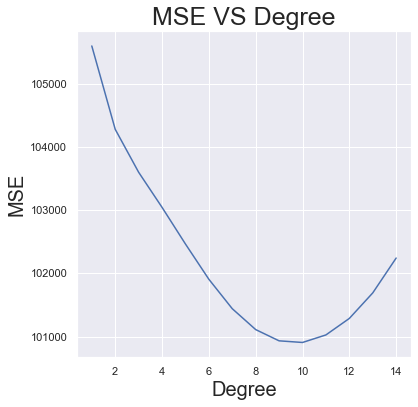

In [114]:
X = MinMaxScaler.fit_transform(X_values.copy())
x_train,x_test,y_train,y_test=train_test_split(X,y,train_size=0.8, random_state = 1)
maxdegree=15 # The maximum degree we would like to test
training_error=[]
cross_validation_error=[]
for d in range(1,maxdegree):
    x_poly_train=PolynomialFeatures(degree=(0,d)).fit_transform(x_train)
    print(np.shape(x_poly_train))
    x_poly_test=PolynomialFeatures(degree=(0,d)).fit_transform(x_test)
    model=Ridge(fit_intercept=False,alpha=0.5)
    model=model.fit(x_poly_train,y_train)
    y_train_pred=model.predict(x_poly_train)
    mse_train=mean_squared_error(y_train,y_train_pred)
    cve=cross_validate(model,x_poly_train,y_train,scoring='neg_mean_squared_error',cv=5,return_train_score=True)
    training_error.append(mse_train)
    cross_validation_error.append(np.mean(np.absolute(cve['test_score'])))
fig,ax=plt.subplots(figsize=(6,6))
print(cross_validation_error)
ax.plot(range(1,maxdegree),np.sqrt(cross_validation_error))
ax.set_xlabel('Degree',fontsize=20)
ax.set_ylabel('MSE',fontsize=20)
ax.set_title('MSE VS Degree',fontsize=25)
plt.show()

Ako koristimo Ridge regresiju u kombinaciji sa PolynomialFeatures, primetit ćemo da dobijamo bolju krivu. Bitno je napomenuti da pri korišćenju Ridge regresije sa većim stepenom (degree=10), postižemo bolji MSE u odnosu na Polynomial regresiju sa nižim stepenom (degree=2). Ovo je očekivano, s obzirom na to da Ridge regresija pomaže u smanjenju problema preprilagođavanja (overfitting), što je često prisutno pri korišćenju viših stepena polinoma.

In [123]:
X = MinMaxScaler.fit_transform(X_values.copy())
x_train,x_test,y_train,y_test=train_test_split(X,y,train_size=0.8, random_state = 1)
d = 10
x_poly_train=PolynomialFeatures(degree=(0,d)).fit_transform(x_train)
x_poly_test=PolynomialFeatures(degree=(0,d)).fit_transform(x_test)
model=Ridge(fit_intercept=False,alpha=0.5)
model=model.fit(x_poly_train,y_train)
y_train_pred=model.predict(x_poly_train)
mse_train=mean_squared_error(y_train,y_train_pred)
cve=cross_validate(model,x_poly_train,y_train,scoring='neg_mean_squared_error',cv=5,return_train_score=True)
cross_validation_error = np.mean(np.absolute(cve['test_score']))

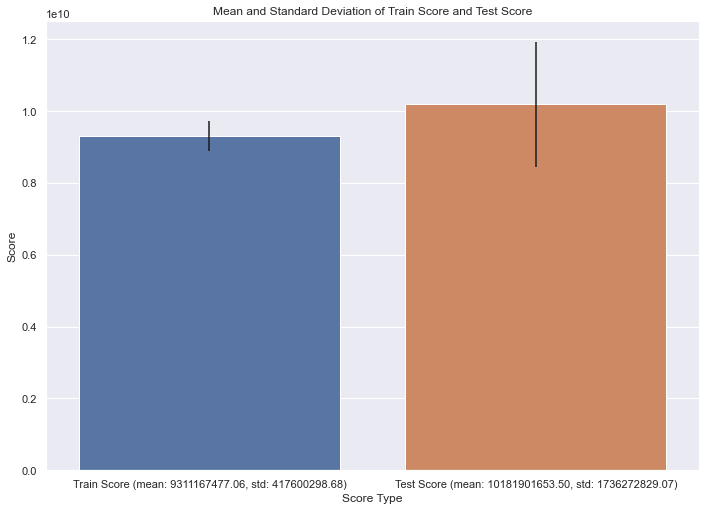

In [121]:
# Calculate mean and std
train_score_mean = np.mean(np.absolute(cve['train_score']))
train_score_std = np.std(cve['train_score'])
test_score_mean = np.mean(np.absolute(cve['test_score']))
test_score_std = np.std(cve['test_score'])

# Create bar plot with error bars
sns.barplot(x=['Train Score (mean: {:.2f}, std: {:.2f})'.format(train_score_mean, train_score_std),
               'Test Score (mean: {:.2f}, std: {:.2f})'.format(test_score_mean, test_score_std)],
            y=[train_score_mean, test_score_mean],
            yerr=[train_score_std, test_score_std])
# Set labels and title
plt.xlabel('Score Type')
plt.ylabel('Score')
plt.title('Mean and Standard Deviation of Train Score and Test Score')

# Show the plot
plt.show()

Za Ridge(degree = 10)
dobija se da u proseku gresimo za sqrt(10181901653.5) = 100908 eura